In [1]:
import rul_datasets
import wandb
import pandas as pd
import numpy as np
import yaml
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import patheffects
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMResults

In [2]:
runs = wandb.Api().runs("tkrokotsch/data-scenarios", filters={"tags": {"$ne": "pretraining", "$in": ["cmapss", "ncmapss"]}})

In [72]:
percent_fail_runs_bins = [0.2, 0.4, 0.6, 0.8, 1.0]

def _parse_fail_runs(row):
    if row["percent_fail_runs"] == -1:
        return 1.0
    bin_idx = np.argmin(np.abs(row["percent_fail_runs"] / ncmapss_max_len[row["target"]] - percent_fail_runs_bins))
    return percent_fail_runs_bins[bin_idx]

In [73]:
df = []
target_val_key = "val/target/rmse/dataloader_idx_1"
for run in tqdm(runs, total=len(runs), unit="run"):
    if not run.state == "finished":
        continue
    config = run.config
    metrics = run.summary_metrics
    val_loss = metrics[target_val_key] if target_val_key in metrics else metrics["val/loss"]
    df.append(
        {
            "dataset": config["source"]["reader"]["dataset"], 
            "source": config["source"]["reader"]["fd"], 
            "target": config["target"]["reader"]["fd"], 
            "percent_broken": config["target"]["reader"]["percent_broken"] or 1.0,
            "percent_fail_runs": config["target"]["reader"]["percent_fail_runs"] or 1.0,
            "id": run.id,
            "approach": config["approach"],
            "test/source/rmse": metrics["test/source/rmse/dataloader_idx_0"],
            "test/target/rmse": metrics["test/target/rmse/dataloader_idx_1"],
            "test/source/score": metrics["test/source/score/dataloader_idx_0"],
            "test/target/score": metrics["test/target/score/dataloader_idx_1"],
            "val/target/rmse": val_loss["best"],
        }
    )
df = pd.DataFrame.from_records(df)

ncmapss_fail_runs = df[df["dataset"] == "ncmapss"].loc[:, ("target", "percent_fail_runs")]
ncmapss_fail_runs["percent_fail_runs"] = ncmapss_fail_runs["percent_fail_runs"].apply(lambda x: -1 if isinstance(x, float) else len(x))
ncmapss_max_len = ncmapss_fail_runs.groupby(["target"]).max()["percent_fail_runs"]
ncmapss_fail_runs["percent_fail_runs"] = ncmapss_fail_runs.apply(_parse_fail_runs, axis=1)
df.loc[df["dataset"] == "ncmapss", "percent_fail_runs"] = ncmapss_fail_runs["percent_fail_runs"]
df["percent_fail_runs"] = df["percent_fail_runs"].astype(float)

df.to_csv("scenarios.csv", index=False)

  0%|          | 0/17220 [00:00<?, ?run/s]

In [74]:
df = pd.read_csv("scenarios.csv")
avg_performance = df.drop(columns="id").groupby(["dataset", "source", "target", "percent_broken", "percent_fail_runs", "approach"]).agg(["mean", "std"])

In [93]:
metric_dict = {"rmse": "RMSE", "score": "RUL Score"}
approach_dict = {"PseudoLabelsApproach": "Pseudo-Labeling", "ConditionalDannApproach": "Conditional DANN", "LatentAlignApproach": "Latent Alignment", "NoAdaptionApproach": "No Adaptation"}

def plot_scenarios(dataset, approach, x_scenario, metric_name="test/target/rmse", ncols=3, figsize=(12, 12), default_y_lims = (15, 50)):
    if x_scenario == "percent_broken":
        y_scenario = "percent_fail_runs"
    elif x_scenario == "percent_fail_runs":
        y_scenario = "percent_broken"
    else:
        raise ValueError("x_scenario must be either 'percent_broken' or 'percent_fail_runs'")
    tasks = avg_performance.loc[dataset].index.droplevel(["percent_broken", "percent_fail_runs", "approach"]).unique()
    fig, axes = plt.subplots(ncols=ncols, nrows=len(tasks) // ncols, figsize=figsize, sharex="all")
    cmap = plt.colormaps.get_cmap("tab10")
    offsets = np.linspace(-0.04, 0.04, 5)
    metric_short = metric_dict[metric_name.split('/')[-1]]
    for ax, (source, target) in zip(axes.ravel(), tasks):
        data = avg_performance.loc[(dataset, source, target, slice(None), slice(None), approach), metric_name]
        baseline = avg_performance.loc[(dataset, source, target, slice(None), slice(None), "NoAdaptionApproach"), metric_name]
        y_lim = (min(default_y_lims[0], data["mean"].min()), max(default_y_lims[1], data["mean"].max() + 5))
        data = data.reset_index().drop(columns=["dataset", "source", "target", "approach"]).pivot(index=x_scenario, columns=y_scenario, values=["mean", "std"])
        for f, factor in enumerate(data.columns.get_level_values(1).unique()):
            x_axis = data.index + offsets[f]
            ax.scatter(x_axis, data.loc[:, ("mean", factor)].values, s=8, label=factor)
            ax.errorbar(x_axis, data.loc[:, ("mean", factor)].values, yerr=data.loc[:, ("std", factor)].values, c=cmap.colors[f], linestyle="none")
        if baseline["mean"].iloc[0] < (y_lim[1] - 2):
            ax.axhline(baseline["mean"].iloc[0], c="gray", linestyle="--", zorder=-1)
            txt = ax.text(0.8, baseline["mean"].iloc[0] * 0.99, "Baseline", c="gray", horizontalalignment="center", verticalalignment="top")
            txt.set_path_effects([patheffects.Stroke(linewidth=2, foreground="white"), patheffects.Normal()])
        else:
            txt = ax.annotate(
                f"Baseline: {baseline['mean'].iloc[0]:0.2f}",
                xy=(0.8, y_lim[1]),
                xytext=(0.8, y_lim[1] - 7),
                c="gray",
                horizontalalignment="center",
                arrowprops={"facecolor": "gray", "edgecolor": "gray", "width": 1, "headwidth": 5, "headlength": 2, "shrink": 0.2}
            )
        txt.set_path_effects([patheffects.Stroke(linewidth=2, foreground="white"), patheffects.Normal()])
        lower = (baseline["mean"].iloc[0] - baseline["std"].iloc[0]).repeat(2)
        upper = (baseline["mean"].iloc[0] + baseline["std"].iloc[0]).repeat(2)
        ax.fill_between([-0.5, 1.5], lower, upper, color= "gray", alpha=0.25, linestyle="dotted", zorder=-2)
        ax.set_ylabel(metric_short.capitalize())
        ax.set_ylim(y_lim)
        ax.set_xlim(0.1, 1.1)
        ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_title(f"{source} ➔ {target}")
    for i in range(ncols):
        axes[-1, i].set_xlabel(" ".join([x.capitalize() for x in x_scenario.split("_")]))
    axes[0, 2].legend(title=" ".join([x.capitalize() for x in y_scenario.split("_")]), loc="upper right", bbox_to_anchor=(1.5, 1))
    fig.suptitle(f"{dataset.upper()} - {approach_dict[approach]} - {metric_short}")
    fig.tight_layout()
    
    return fig

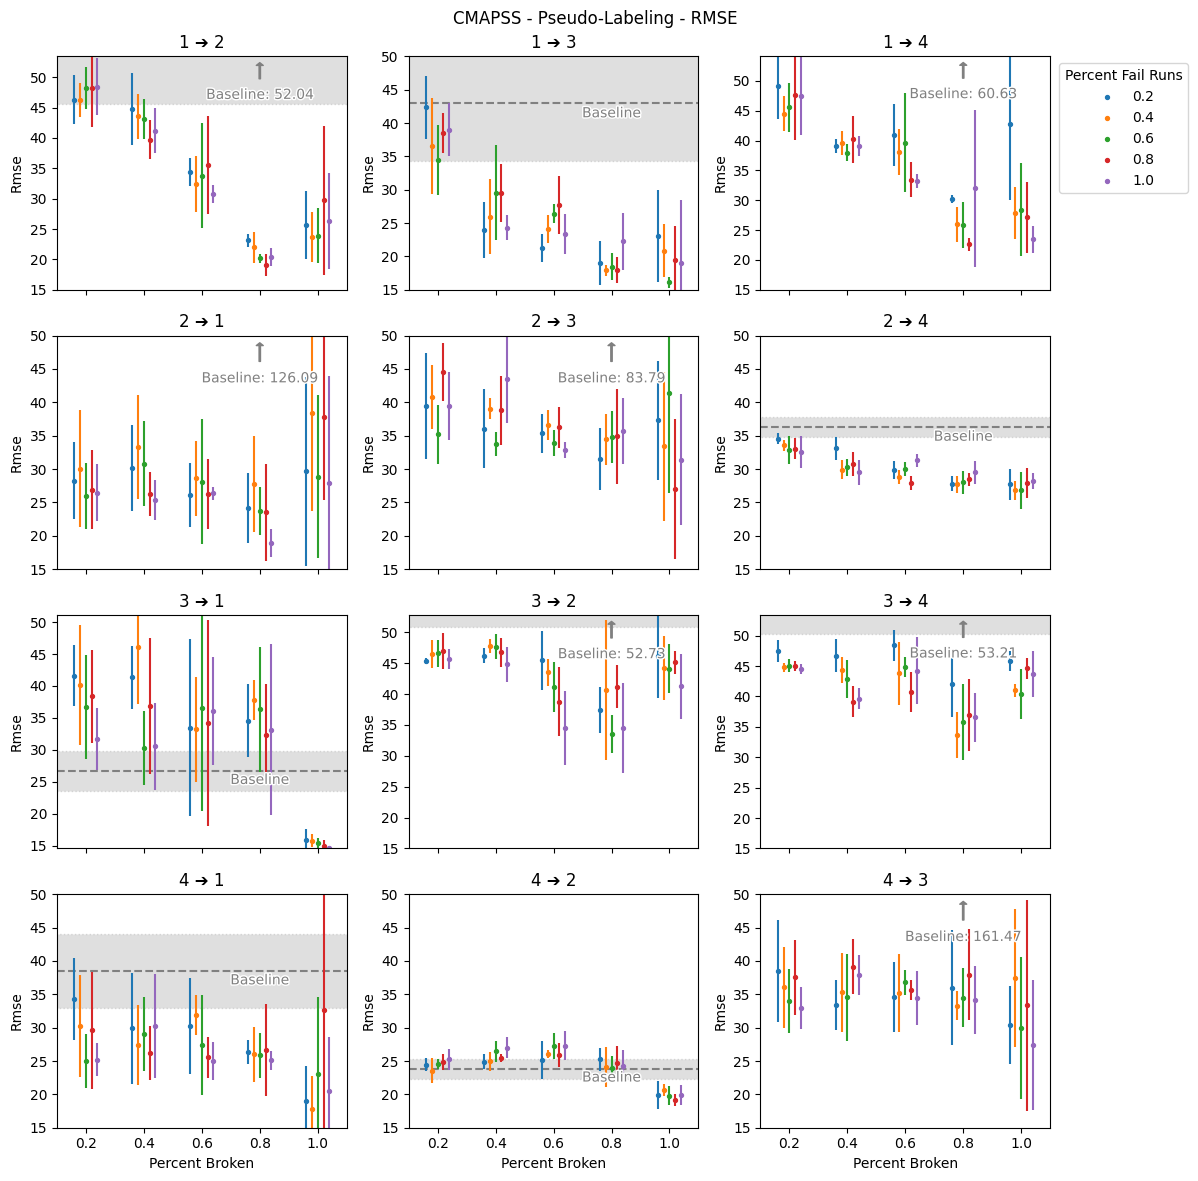

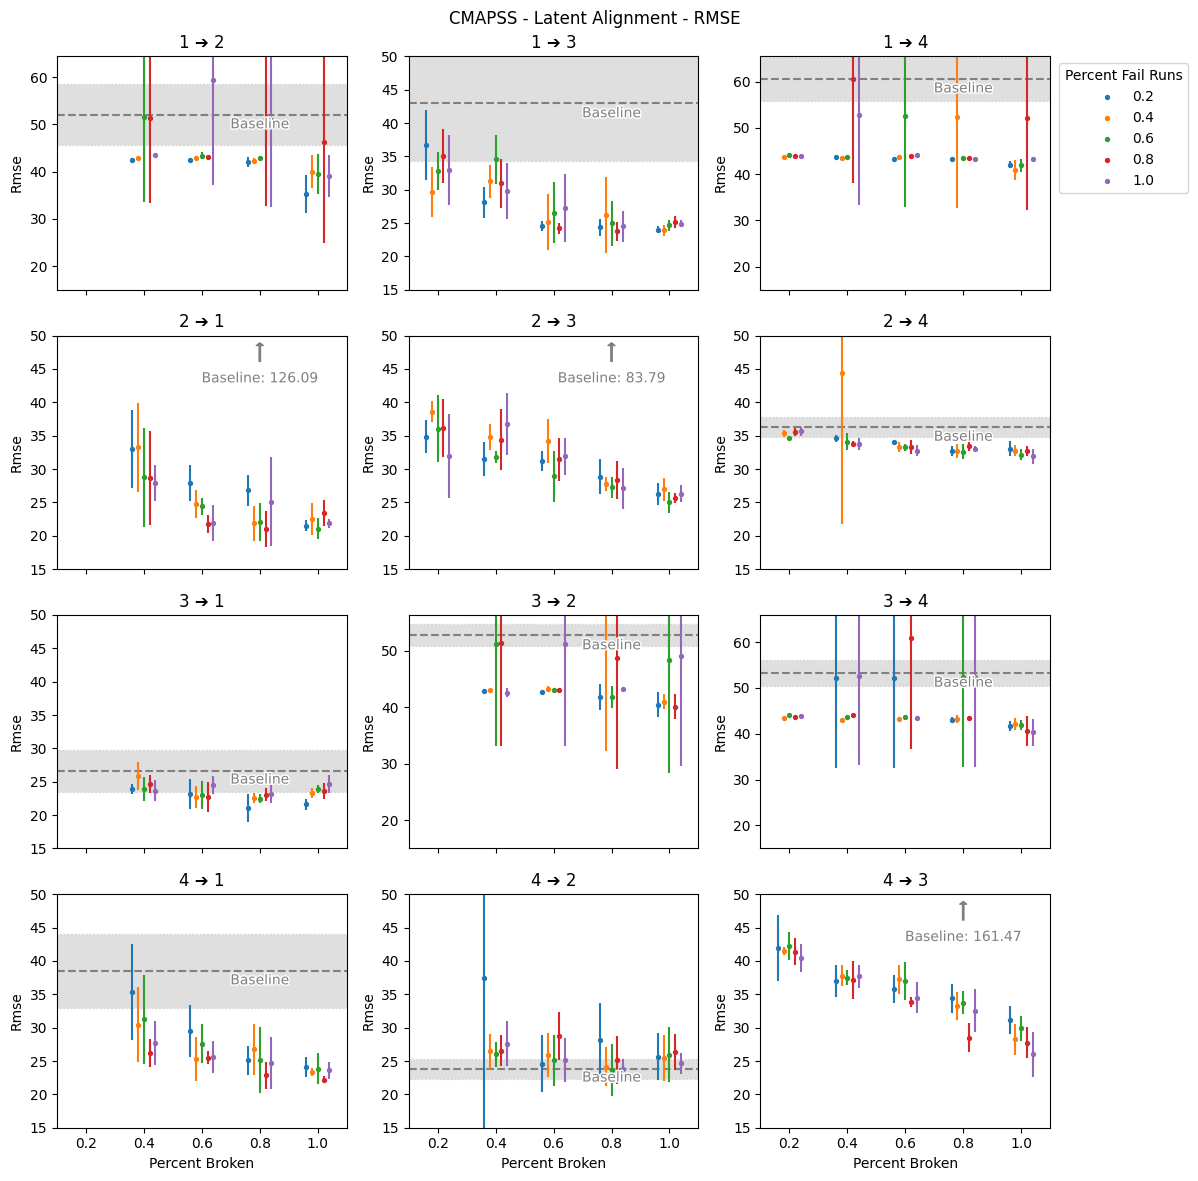

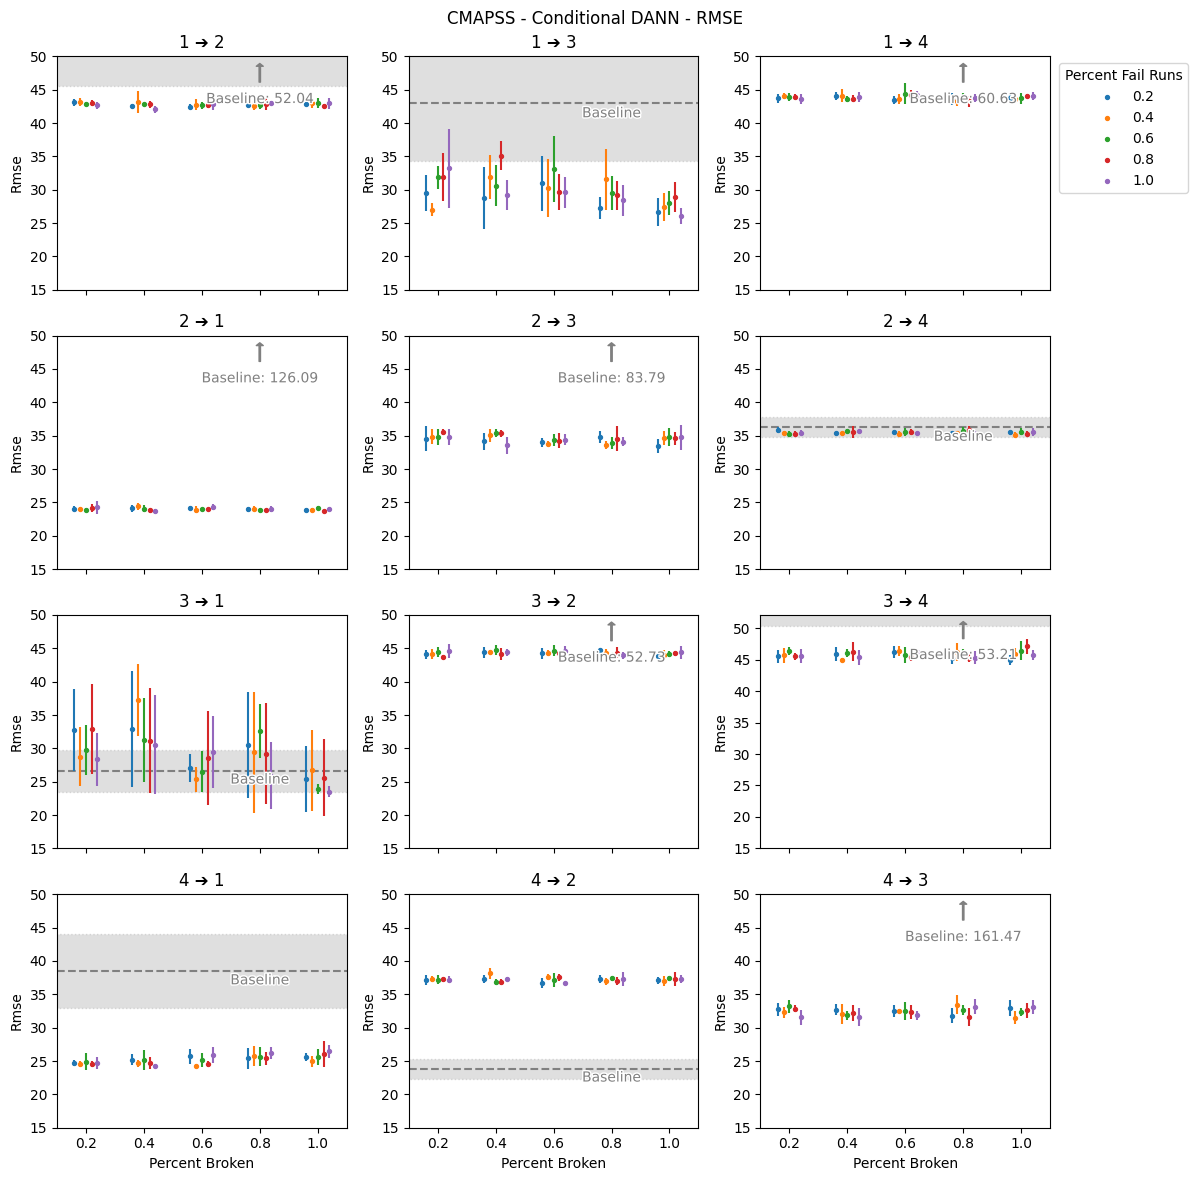

In [94]:
for approach in ["PseudoLabelsApproach", "LatentAlignApproach", "ConditionalDannApproach"]:
    fig = plot_scenarios("cmapss", approach, "percent_broken")
    fig.savefig(f"results_cmapss_{approach}_percent_broken_rmse.svg")

In [77]:
for approach in ["PseudoLabelsApproach", "LatentAlignApproach", "ConditionalDannApproach"]:
    # fig = plot_scenarios("cmapss", approach, "percent_broken", metric_name="test/target/score")
    # fig.savefig(f"results_cmapss_{approach}_percent_broken_score.svg")
    pass

In [78]:
name_dict = {
    "Intercept": "Intercept",
    "percent_broken": '$p_("degraded")$',
    "percent_fail_runs": '$p_("entity")$',
    "Group Var": "Task",
}
def calc_linear_mixed_model(metric_name, dataset, logaritmic=False):
    table = [[f"[{name}]"] for name in name_dict.values()]
    perf = df.drop(columns="id").set_index(["dataset", "source", "target", "percent_broken", "percent_fail_runs", "approach"])
    perf = perf.loc[dataset]
    for approach in ["PseudoLabelsApproach", "LatentAlignApproach", "ConditionalDannApproach"]:
        regression_data = perf.loc[(slice(None), slice(None), slice(None), slice(None), approach), metric_name]
        regression_data = regression_data.reset_index().drop(columns=["approach"]).rename({metric_name: "metric"}, axis=1)
        if logaritmic:
            regression_data["metric"] = np.log(regression_data["metric"])
        groups = regression_data[['source', 'target']].apply(lambda x: f"{x['source']} ➔ {x['target']}", axis=1)
        mdf: MixedLMResults = smf.mixedlm("metric ~ percent_broken + percent_fail_runs", regression_data, groups=groups).fit()
        for i, ((name, param), (_, p)) in enumerate(zip(mdf.params.items(), mdf.pvalues.items())):
            table[i].extend([f'[#num("{param:.2f}")]', f'[#num("{p:.2e}")]'])
    table = ",\n".join([", ".join(row) for row in table])
    
    return table

In [79]:
print(calc_linear_mixed_model("test/target/rmse", "cmapss"))

[Intercept], [#num("41.26")], [#num("5.23e-109")], [#num("39.19")], [#num("6.38e-51")], [#num("35.91")], [#num("2.64e-60")],
[$p_("degraded")$], [#num("-11.87")], [#num("1.74e-79")], [#num("-8.10")], [#num("5.62e-28")], [#num("-0.89")], [#num("7.51e-06")],
[$p_("entity")$], [#num("-2.30")], [#num("2.50e-04")], [#num("0.42")], [#num("5.32e-01")], [#num("-0.03")], [#num("8.76e-01")],
[Task], [#num("0.79")], [#num("2.07e-02")], [#num("1.60")], [#num("2.02e-02")], [#num("12.23")], [#num("1.94e-02")]


In [81]:
print(calc_linear_mixed_model("test/target/score", "cmapss", logaritmic=True))

[Intercept], [#num("10.95")], [#num("1.32e-187")], [#num("10.31")], [#num("1.65e-101")], [#num("9.47")], [#num("1.47e-114")],
[$p_("degraded")$], [#num("-1.30")], [#num("1.87e-23")], [#num("-1.52")], [#num("1.50e-69")], [#num("0.07")], [#num("3.03e-02")],
[$p_("entity")$], [#num("-0.83")], [#num("1.87e-10")], [#num("0.10")], [#num("1.89e-01")], [#num("0.02")], [#num("4.90e-01")],
[Task], [#num("0.75")], [#num("2.08e-02")], [#num("4.20")], [#num("1.98e-02")], [#num("19.10")], [#num("1.95e-02")]


In [89]:
def calc_ranks(metric_name, dataset):
    to_be_ranked = avg_performance.loc[dataset, (slice(None), "mean")]
    to_be_ranked.columns = to_be_ranked.columns.droplevel(1)
    to_be_ranked = to_be_ranked.reset_index().pivot_table(index=["source", "target", "percent_broken", "percent_fail_runs"], columns="approach", values=metric_name)
    baseline = to_be_ranked.loc[(slice(None), slice(None), 0.8, 1.0), "NoAdaptionApproach"]
    baseline.index = baseline.index.droplevel(["percent_broken", "percent_fail_runs"])
    to_be_ranked.loc[(slice(None), slice(None), slice(None), slice(None)), "NoAdaptionApproach"] = baseline
    ranked = to_be_ranked.groupby(level=[2, 3]).rank(axis=1).fillna(4.0)
    ranked = ranked.groupby(level=[2, 3]).mean()
    pivot_ranked = ranked.reset_index().pivot(index=["percent_broken"], columns=["percent_fail_runs"], values=["NoAdaptionApproach", "PseudoLabelsApproach", "LatentAlignApproach", "ConditionalDannApproach"])
    pivot_ranked = pivot_ranked.swaplevel(axis=1)
    
    factors = [0.2, 0.4, 0.6, 0.8, 1.0]
    colors = ["#text(fill: blue)", "#text(fill: orange)", "#text(fill: green)", "#text(fill: gray)"]
    table = [["table.header[]" + "".join([f"[{f}]" for f in factors])]]
    table += [[f"[{f}]"] for f in factors]
    for failed in factors:
        for i, broken in enumerate(factors, start=1):
            table[i].append([])
            for a, approach in enumerate(["PseudoLabelsApproach", "LatentAlignApproach", "ConditionalDannApproach", "NoAdaptionApproach"]):
                data = pivot_ranked.loc[broken, (failed, approach)]
                if a and a % 2 == 0:
                    table[i][-1].append("\\")
                table[i][-1].append(colors[a] + f'[#num("{data:.2f}")]')
            table[i][-1] = "[{0}]".format(" ".join(table[i][-1]))
    table = ",\n".join([", ".join(row) for row in table])
    
    return table

In [90]:
print(calc_ranks("test/target/rmse", "cmapss"))

table.header[][0.2][0.4][0.6][0.8][1.0],
[0.2], [#text(fill: blue)[#num("2.17")] #text(fill: orange)[#num("3.58")] \ #text(fill: green)[#num("1.33")] #text(fill: gray)[#num("2.92")]], [#text(fill: blue)[#num("2.17")] #text(fill: orange)[#num("2.92")] \ #text(fill: green)[#num("1.67")] #text(fill: gray)[#num("3.25")]], [#text(fill: blue)[#num("2.17")] #text(fill: orange)[#num("3.08")] \ #text(fill: green)[#num("1.58")] #text(fill: gray)[#num("3.17")]], [#text(fill: blue)[#num("2.25")] #text(fill: orange)[#num("3.00")] \ #text(fill: green)[#num("1.58")] #text(fill: gray)[#num("3.17")]], [#text(fill: blue)[#num("2.25")] #text(fill: orange)[#num("2.92")] \ #text(fill: green)[#num("1.67")] #text(fill: gray)[#num("3.17")]],
[0.4], [#text(fill: blue)[#num("2.17")] #text(fill: orange)[#num("2.17")] \ #text(fill: green)[#num("2.08")] #text(fill: gray)[#num("3.58")]], [#text(fill: blue)[#num("2.25")] #text(fill: orange)[#num("2.00")] \ #text(fill: green)[#num("2.25")] #text(fill: gray)[#num("3.5

In [91]:
print(calc_ranks("test/target/score", "cmapss"))

table.header[][0.2][0.4][0.6][0.8][1.0],
[0.2], [#text(fill: blue)[#num("2.42")] #text(fill: orange)[#num("3.75")] \ #text(fill: green)[#num("1.25")] #text(fill: gray)[#num("2.58")]], [#text(fill: blue)[#num("2.50")] #text(fill: orange)[#num("3.17")] \ #text(fill: green)[#num("1.33")] #text(fill: gray)[#num("3.00")]], [#text(fill: blue)[#num("2.17")] #text(fill: orange)[#num("3.33")] \ #text(fill: green)[#num("1.42")] #text(fill: gray)[#num("3.08")]], [#text(fill: blue)[#num("2.00")] #text(fill: orange)[#num("3.42")] \ #text(fill: green)[#num("1.50")] #text(fill: gray)[#num("3.08")]], [#text(fill: blue)[#num("2.00")] #text(fill: orange)[#num("3.50")] \ #text(fill: green)[#num("1.42")] #text(fill: gray)[#num("3.08")]],
[0.4], [#text(fill: blue)[#num("3.17")] #text(fill: orange)[#num("2.00")] \ #text(fill: green)[#num("1.58")] #text(fill: gray)[#num("3.25")]], [#text(fill: blue)[#num("2.75")] #text(fill: orange)[#num("2.33")] \ #text(fill: green)[#num("1.50")] #text(fill: gray)[#num("3.4

KeyError: ('ncmapss', 3, 1, slice(None, None, None), slice(None, None, None), 'ConditionalDannApproach')

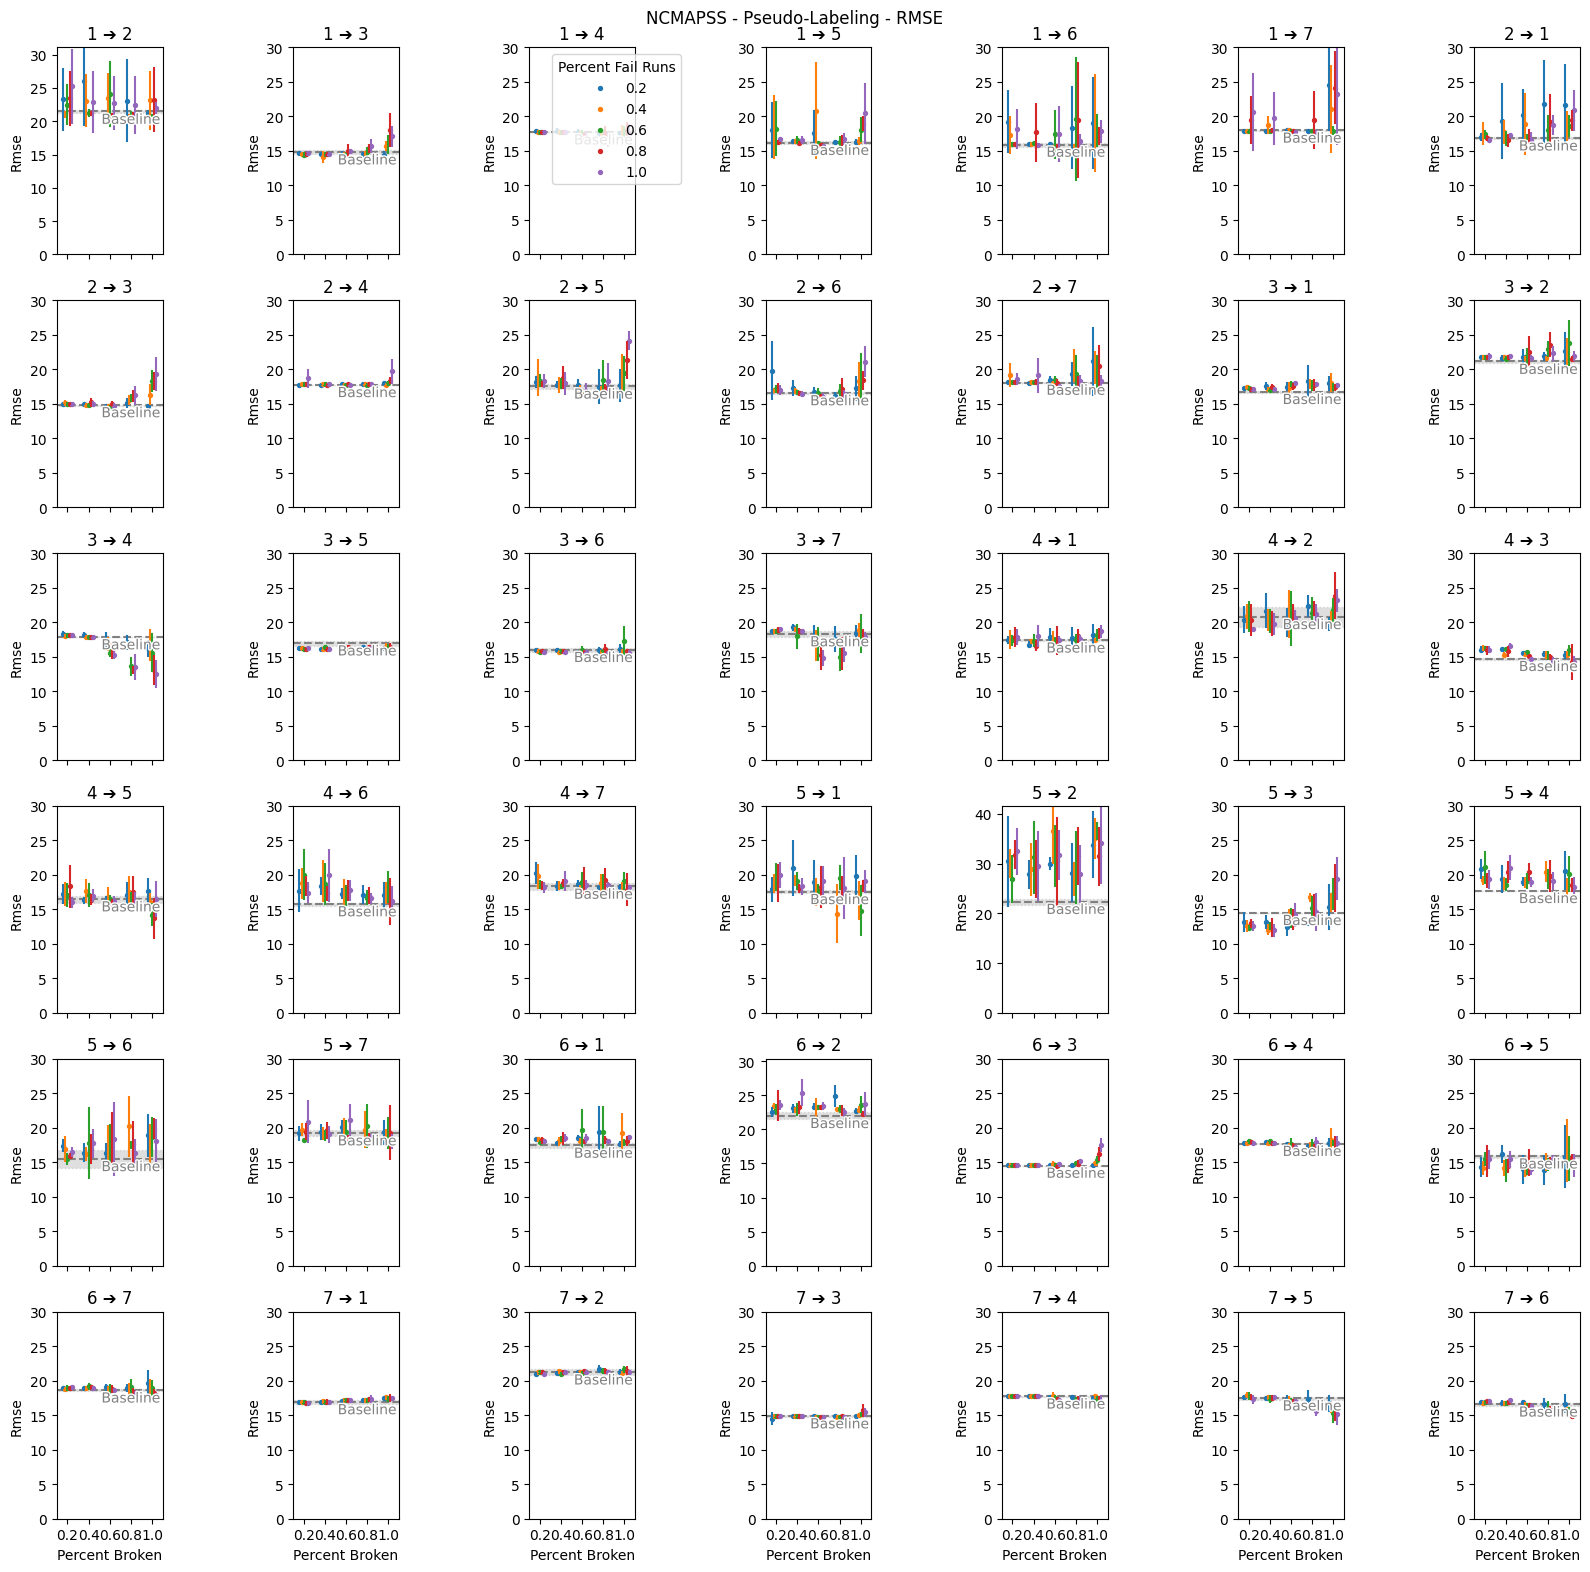

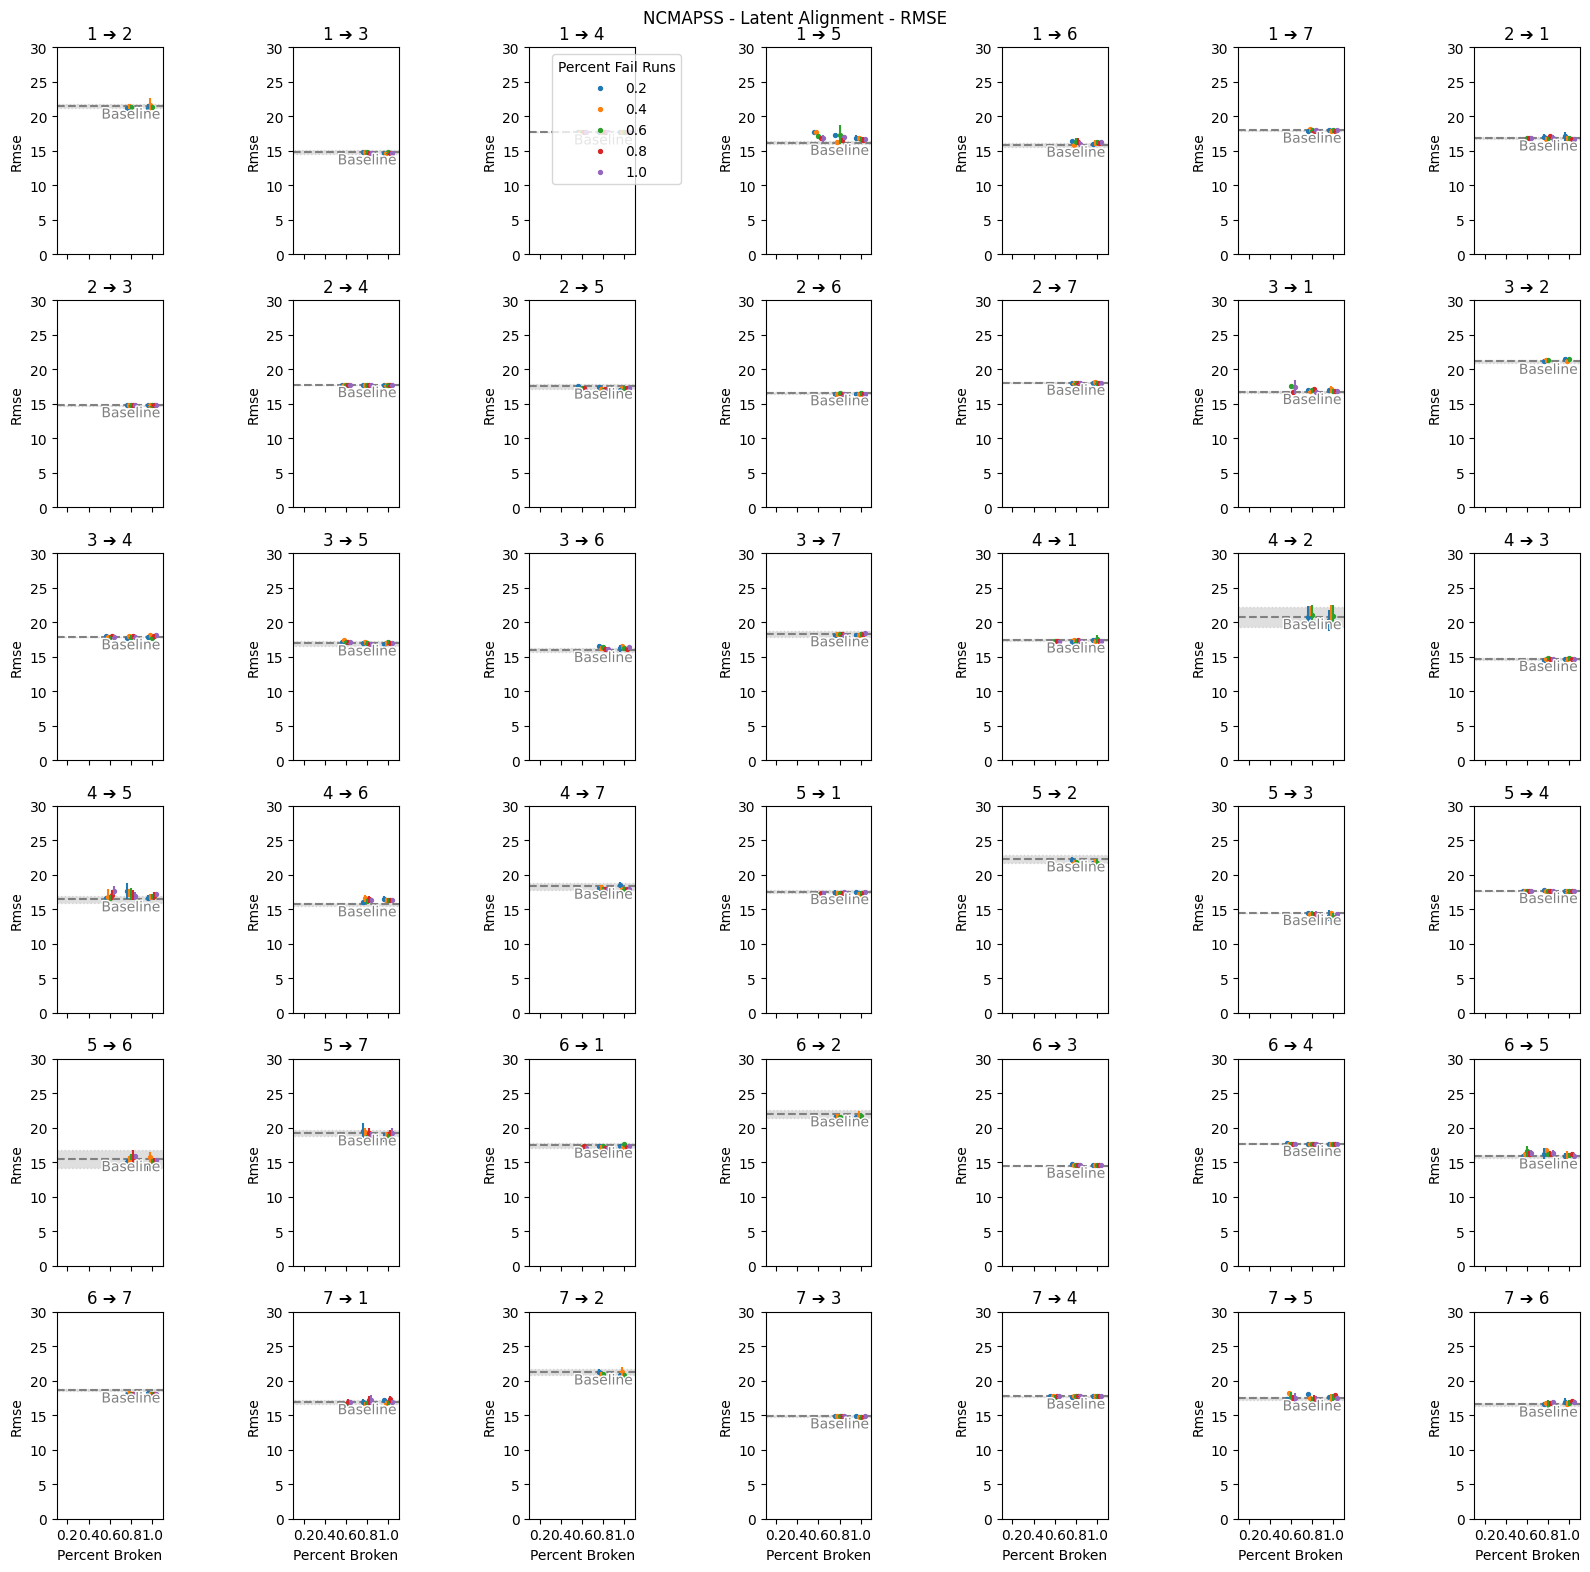

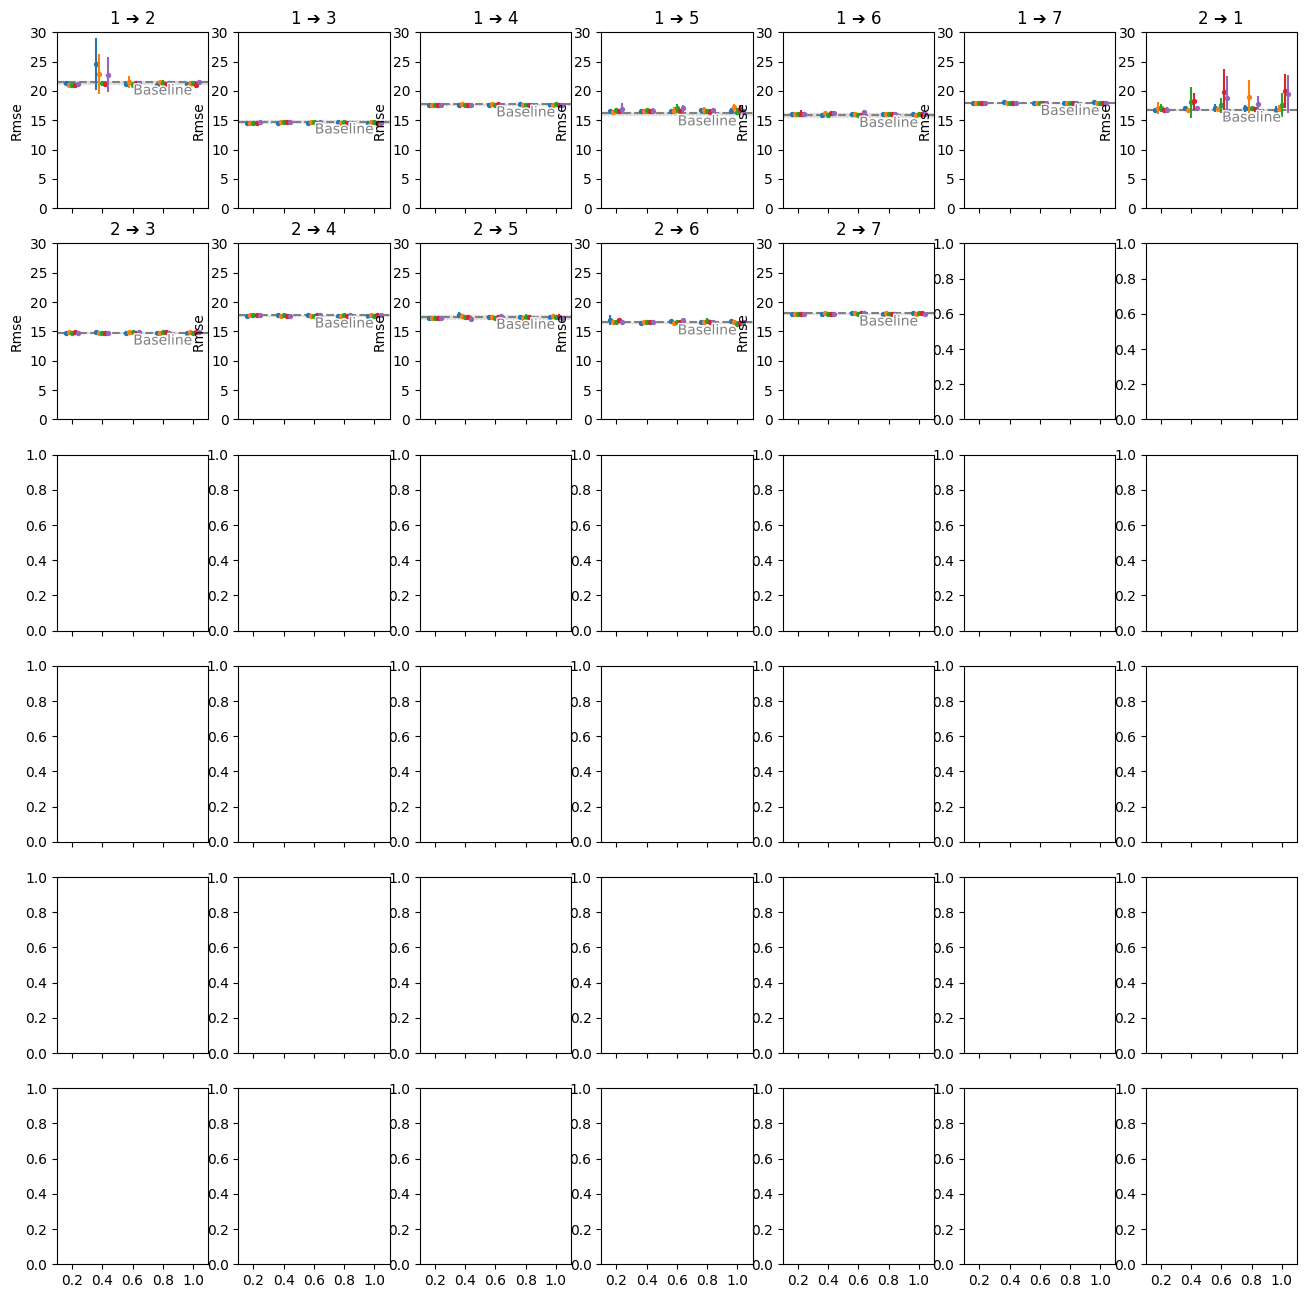

In [96]:
for approach in ["PseudoLabelsApproach", "LatentAlignApproach", "ConditionalDannApproach"]:
    fig = plot_scenarios("ncmapss", approach, "percent_broken", ncols=7, default_y_lims=(0, 30), figsize=(16, 16))
    fig.savefig(f"results_ncmapss_{approach}_percent_broken_rmse.svg")

In [56]:
from pathlib import Path
import yaml

runs = Path("clipping-investigation/wandb").glob("*")
runs = {run.name.split("-")[-1]: run / "files" / "config.yaml" for run in runs if run.is_dir()}
for run_id, run in runs.items():
    with open(run, mode="rt") as f:
        runs[run_id] = yaml.load(f, yaml.SafeLoader)
pretraining = {run_id: run for run_id, run in runs.items() if "approach" not in run}
runs = {run_id: run for run_id, run in runs.items() if "approach" in run}

KeyboardInterrupt: 

In [21]:
import rul_datasets

fd4 = rul_datasets.CmapssReader(4, window_size=30)
dm = rul_datasets.RulDataModule(fd4, batch_size=32)
dm.setup()
dataset = dm.test_dataloader()

/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 9 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 18 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 27 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 124 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 140 of CMAPSS FD004 is shorter than window size

In [24]:
from rul_adapt.approach import SupervisedApproach
import torch

predictions = {}
for run_id, config in tqdm(runs.items()):
    model_path = next(Path(f"clipping-investigation/test/{run_id}/checkpoints").glob("*.ckpt"))
    model = SupervisedApproach.load_from_checkpoint(str(model_path), map_location="cpu")
    model.eval()
    predictions[run_id] = []
    for batch, labels in dataset:
        predictions[run_id].append((model(batch).squeeze() - labels).detach().numpy())
    predictions[run_id] = np.concatenate(predictions[run_id])

  0%|          | 0/10 [00:00<?, ?it/s]

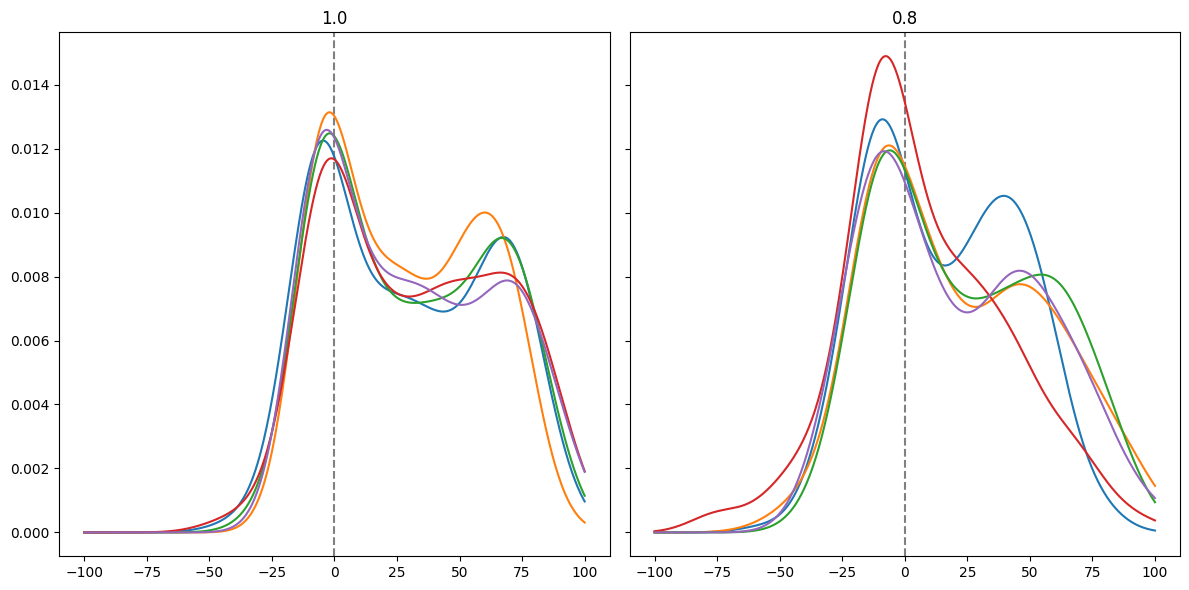

In [46]:
from scipy import stats

fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharex="all", sharey="all")
complete = {run_id: (config, predictions[run_id]) for run_id, config in runs.items() if config["target"]["value"]["reader"]["percent_broken"] == 1.0}
truncated = {run_id: (config, predictions[run_id]) for run_id, config in runs.items() if config["target"]["value"]["reader"]["percent_broken"] == 0.8}
for mode, ax in zip([complete, truncated], axes.ravel()):
    x = np.linspace(-100, 100, 500)
    ax.set_title("1.0" if mode is complete else "0.8")
    ax.axvline(0, c="gray", linestyle="--")
    for run_id, (_, preds) in mode.items():
        density = stats.gaussian_kde(preds, "scott")
        ax.plot(x, density(x))
fig.tight_layout()

In [65]:
from rul_adapt.approach import generate_pseudo_labels

pseudo_labels_complete = []
pseudo_labels_truncated = []
for run_id, config in tqdm(pretraining.items()):
    model_path = next(Path(f"clipping-investigation/test/{run_id}/checkpoints").glob("*.ckpt"))
    model = SupervisedApproach.load_from_checkpoint(str(model_path), map_location="cpu")
    model.eval()
    dm.reader.percent_broken = 1.0
    pseudo_labels_complete.append(generate_pseudo_labels(dm, model))
    dm.reader.percent_broken = 0.8
    pseudo_labels_truncated.append(generate_pseudo_labels(dm, model))
pseudo_labels_complete = np.concatenate(pseudo_labels_complete)
pseudo_labels_truncated = np.concatenate(pseudo_labels_truncated)

  0%|          | 0/8 [00:00<?, ?it/s]

/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_adapt/approach/pseudo_labels.py:83: UserWarning: At least one of the generated pseudo labels is greater than the maximum RUL of the dataset. This may lead to unexpected results when trying to instantiate a reader with these pseudo labels.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_adapt/approach/pseudo_labels.py:83: UserWarning: At least one of the generated pseudo labels is greater than the maximum RUL of the dataset. This may lead to unexpected results when trying to instantiate a reader with these pseudo labels.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_adapt/approach/pseudo_labels.py:83: UserWarning: At least one of the generated pseudo labels is greater than the maximum RUL of the dataset. This may lead to unexpected results when trying to instantiate a reader with these pseudo labels.
  warnings.warn(
/home/tilman/Programming/

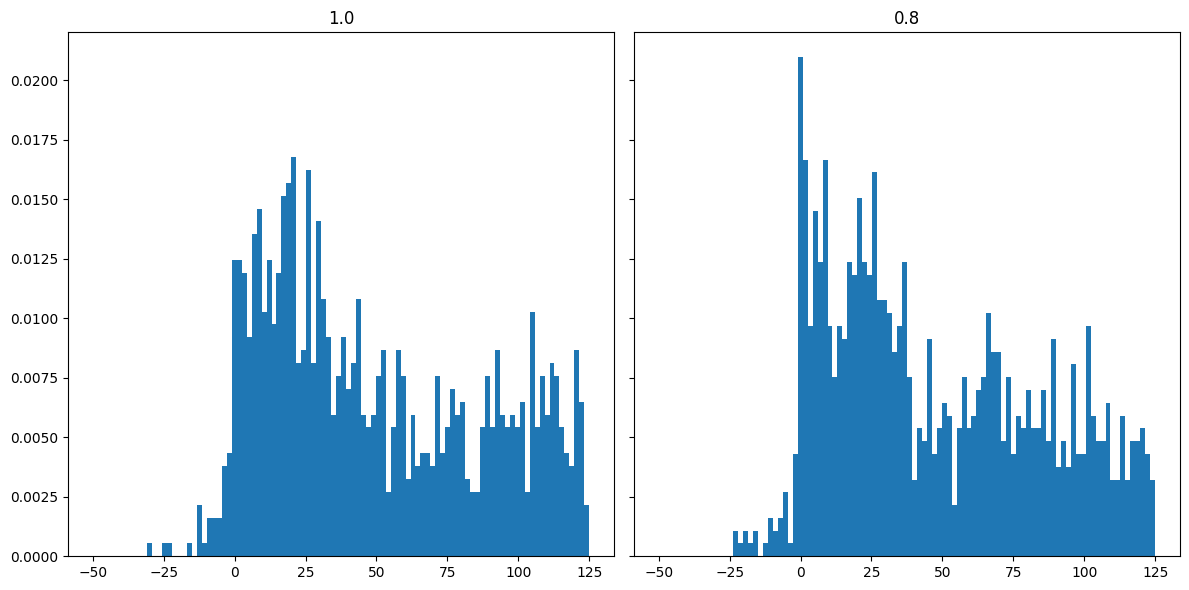

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharex="all", sharey="all")
axes[0].hist(pseudo_labels_complete, bins=100, range=(-50, 125), density=True)
axes[1].hist(pseudo_labels_truncated, bins=100, range=(-50, 125), density=True)
axes[0].set_title("1.0")
axes[1].set_title("0.8")
fig.tight_layout()

In [75]:
dm.reader.percent_broken = 0.8
dm.setup()
labels = [run[-1] for run in dm.data["dev"][1]]
labels = np.stack(labels)

/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 9 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 18 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 27 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 124 of CMAPSS FD004 is shorter than window size 30 and will be zero-padded.
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_datasets/reader/cmapss.py:323: UserWarning: Run 140 of CMAPSS FD004 is shorter than window size

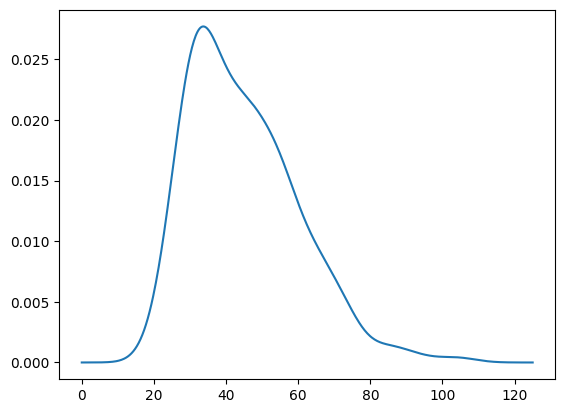

In [76]:
density = stats.gaussian_kde(labels, "scott")
x = np.linspace(0, 125, 500)
plt.plot(x, density(x))

In [3]:
import rul_datasets
import rul_adapt
import torch
import numpy as np
from crule.run.utils import NcmapssAverageExtractor

fd1 = rul_datasets.NCmapssReader(3, padding_value=-1)
dm = rul_datasets.RulDataModule(fd1, batch_size=32, window_size=30, feature_extractor=NcmapssAverageExtractor(num_sections=2, padding_value=-1))
dm.setup()

/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version

/home/tilman/Programming/crule/.venv/lib/python3.9/site-packages/rul_adapt/utils.py:112: UserWarning: The following kwargs were passed but do not start with 'optim_' or 'scheduler_' and therefore will be ignored: ['alpha_healthy', 'alpha_direction', 'alpha_level', 'alpha_fusion', 'labels_as_percentage'].
  warnings.warn(


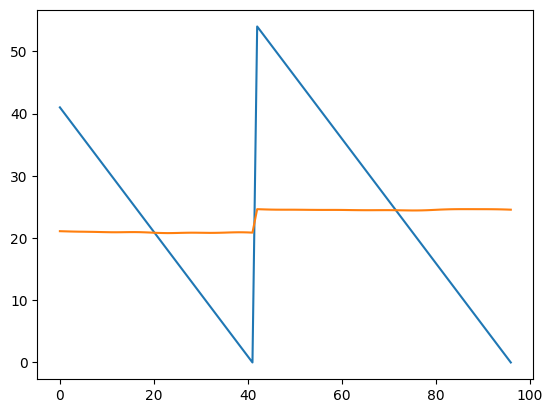

In [27]:
import matplotlib.pyplot as plt

model = rul_adapt.approach.SupervisedApproach.load_from_checkpoint("/home/tilman/Programming/crule/ncmapss_check/test/x6a0649a/checkpoints/epoch=1-step=38.ckpt")
model.eval()

dataset = torch.utils.data.DataLoader(dm.to_dataset("val"), batch_size=32)
predictions = []
labels = []
for batch, label in dataset:
    predictions.append(model(batch).detach().numpy())
    labels.append(label.detach().numpy())
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

plt.plot(labels)
plt.plot(predictions)

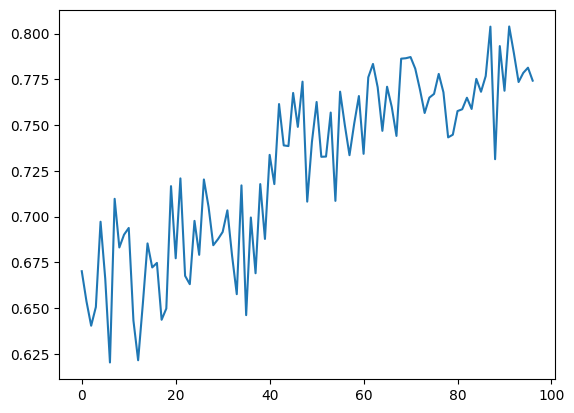

In [21]:
plt.plot([dataset.dataset[i][0][7, -1].item() for i in range(len(dataset.dataset))])